In [100]:
import torch
from matplotlib import pyplot as plt

#checkpoint = torch.load('models/just_pitches_no_drums_warmup2')
checkpoint = torch.load('models/just_pitches_warmup_trackoh')

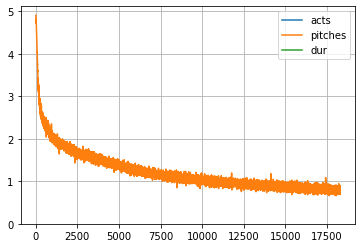

In [101]:
losses = checkpoint['losses']

#plt.plot(range(1, len(losses['tot'])+1), losses['tot'], label='Loss')
plt.plot(range(1, len(losses['acts'])+1), losses['acts'], label='acts')
plt.plot(range(1, len(losses['pitches'])+1), losses['pitches'], label='pitches')
plt.plot(range(1, len(losses['dur'])+1), losses['dur'], label='dur')
#plt.plot(range(1, len(losses['kld'])+1), losses['kld'], label='kld')
plt.grid()
plt.ylim(0)
plt.legend()

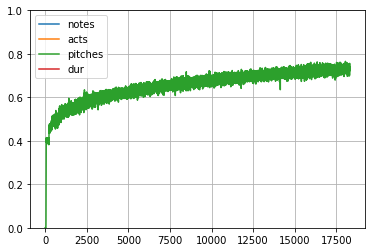

In [102]:
accs = checkpoint['accuracies']
plt.plot(range(1, len(accs['notes'])+1), accs['notes'], label='notes')
plt.plot(range(1, len(accs['acts'])+1), accs['acts'], label='acts')
plt.plot(range(1, len(accs['pitches'])+1), accs['pitches'], label='pitches')
plt.plot(range(1, len(accs['dur'])+1), accs['dur'], label='dur')
plt.grid()
plt.ylim(0, 1)
plt.legend()

(0.0, 18794.95)

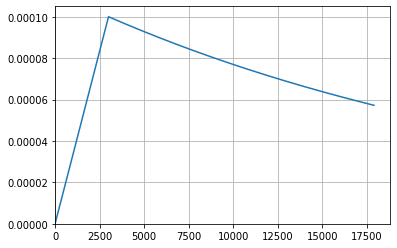

In [99]:
lrs = checkpoint['lrs']
plt.plot(range(1, len(lrs)+1), lrs, label='Lr')
plt.grid()
plt.ylim(0)
plt.xlim(0)

In [93]:
lrs[-1]

6.64866824513178e-05

In [94]:
losses = checkpoint['losses']
losses['pitches'][-10:]

[0.9596696496009827,
 0.8751183748245239,
 0.876893937587738,
 0.8841278553009033,
 0.851455569267273,
 0.8841250538825989,
 0.9542986154556274,
 0.8851467967033386,
 0.8562086224555969,
 0.8752449154853821]

In [95]:
accs = checkpoint['accuracies']
accs['pitches'][-10:]

[0.6898079514503479,
 0.7198595404624939,
 0.7088552713394165,
 0.7135396003723145,
 0.7098196148872375,
 0.7119901180267334,
 0.6935692429542542,
 0.7044660449028015,
 0.7130621075630188,
 0.7193772792816162]

In [82]:
import torch
torch.cuda.set_device(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
print("Device:", device)
print("Current device idx:", torch.cuda.current_device())

Device: cpu
Current device idx: 0


Reconstruct

In [83]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.data import Data
import itertools


def unpackbits(x, num_bits):

    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")

    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])

    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])


class MIDIDataset(Dataset):

    def __init__(self, dir):
        self.dir = dir

    def __len__(self):
        _, _, files = next(os.walk(self.dir))
        return len(files)

    
    def __get_track_edges(self, acts, edge_type_ind=0):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        
        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        track_edges = []

        for track in range(a_t.shape[1]):
            tr_inds = list(inds[inds[:,1] == track])
            e_inds = [(tr_inds[i],
                    tr_inds[i+1]) for i in range(len(tr_inds)-1)]
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, e[1][0]-e[0][0]) for e in e_inds]
            track_edges.extend(edges)

        return np.array(track_edges, dtype='long')

    
    def __get_onset_edges(self, acts, edge_type_ind=1):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        onset_edges = []

        for i in ts_inds:
            ts_acts_inds = list(inds[inds[:,0] == i])
            if len(ts_acts_inds) < 2:
                continue
            e_inds = list(itertools.combinations(ts_acts_inds, 2))
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, 0) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            onset_edges.extend(edges)
            onset_edges.extend(inv_edges)

        return np.array(onset_edges, dtype='long')


    def __get_next_edges(self, acts, edge_type_ind=2):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        next_edges = []

        for i in range(len(ts_inds)-1):

            ind_s = ts_inds[i]
            ind_e = ts_inds[i+1]
            s = inds[inds[:,0] == ind_s]
            e = inds[inds[:,0] == ind_e]

            e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
            edges = [(labels[tuple(e[0])],labels[tuple(e[1])], edge_type_ind, ind_e-ind_s) for e in e_inds]

            next_edges.extend(edges)

        return np.array(next_edges, dtype='long')


    def __getitem__(self, idx):

        # Load tensors
        sample_path = os.path.join(self.dir, str(idx) + ".npz")
        data = np.load(sample_path)

        seq_tensor = data["seq_tensor"]
        seq_acts = data["seq_acts"]
        
        # Construct src_key_padding_mask (PAD = 130)
        src_mask = torch.from_numpy((seq_tensor[..., 0] == 130))

        # From decimals to one-hot (pitch)
        pitches = seq_tensor[:, :, :, 0]
        onehot_p = np.zeros((pitches.shape[0]*pitches.shape[1]*pitches.shape[2],
                            131), dtype=float)
        onehot_p[np.arange(0, onehot_p.shape[0]), pitches.reshape(-1)] = 1.
        onehot_p = onehot_p.reshape(-1, pitches.shape[1], seq_tensor.shape[2], 131)

        # From decimals to one-hot (dur)
        #durs = seq_tensor[:, :, :, 1]
        #onehot_d = np.zeros((durs.shape[0]*durs.shape[1]*durs.shape[2],
        #                    99), dtype=float)
        #onehot_d[np.arange(0, onehot_d.shape[0]), durs.reshape(-1)] = 1.
        #onehot_d = onehot_d.reshape(-1, durs.shape[1], seq_tensor.shape[2], 99)
        #bin_durs = unpackbits(durs, 9)[:, :, :, ::-1]
        
        
        # Concatenate pitches and durations
        #new_seq_tensor = np.concatenate((onehot_p, onehot_d),
        #                     axis=-1)
        new_seq_tensor = onehot_p
        
        # Construct graph from boolean activations
        # Todo: optimize and refactor
        track_edges = self.__get_track_edges(seq_acts)
        onset_edges = self.__get_onset_edges(seq_acts)
        next_edges = self.__get_next_edges(seq_acts)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        no_edges = (len(track_edges) == 0 and 
                    len(onset_edges) == 0 and len(next_edges) == 0)
        if not no_edges:
            edge_list = np.concatenate([x for x in edges
                                          if x.size > 0])
            edge_list = torch.from_numpy(edge_list)
        
        # Adapt tensor to torch_geometric's Data
        # Todo: re-check no edges case
        edge_index = (torch.LongTensor([[], []]) if no_edges else
                               edge_list[:, :2].t().contiguous())
        edge_attr = (torch.Tensor([[0, 0]]) if no_edges else
                                       edge_list[:, 2:])
        
        
        #n = seq_acts.shape[0]*seq_acts.shape[1]
        n = torch.sum(torch.Tensor(seq_acts), dtype=torch.long) # sparse
        graph = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=n)
        
        # Todo: start with torch at mount
        return torch.Tensor(new_seq_tensor), torch.Tensor(seq_acts), graph, src_mask


In [84]:
import torch
from torch import nn, Tensor
from torch_geometric.nn.conv import GCNConv
import torch.nn.functional as F
import math
import torch.optim as optim
from torch_scatter import scatter_mean


# Todo: check and think about max_len
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 256):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *                     \
                             (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class GCN(nn.Module):
    
    def __init__(self, features_dims=[256, 256, 256, 256], num_relations=3,
                    dropout=0.1):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(features_dims)-1):
            self.layers.append(GCNConv(features_dims[i], features_dims[i+1]))
        self.p = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for layer in self.layers:
            x = F.dropout(x, p=self.p, training=self.training)
            x = layer(x, edge_index)
            x = F.relu(x)

        return x


class Encoder(nn.Module):

    # 140 = 128+3+9
    def __init__(self, d_token=131, d_transf=256, nhead_transf=4, 
                 num_layers_transf=6, dropout=0.1):
        super().__init__()

        # Todo: one separate encoder for drums
        # Transformer Encoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        transf_layer = nn.TransformerEncoderLayer(
            d_model=d_transf,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            transf_layer,
            num_layers=num_layers_transf
        )

        # Graph encoder
        self.graph_encoder = GCN(dropout=dropout)

        # (LSTM)
        
        # Linear layers that compute the final mu and log_var
        # Todo: as parameters
        self.linear_mu = nn.Linear(256, 256)
        self.linear_log_var = nn.Linear(256, 256)

        
    def forward(self, x_seq, x_acts, x_graph, src_mask):

        # Collapse track (and optionally batch) dimension
        #print("Init input:", x_seq.size())
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        #print("Reshaped input:", x_seq.size())
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]

        # Compute embeddings
        embs = self.embedding(x_seq)
        #print("Embs:", embs.size())

        # batch_first = False
        embs = embs.permute(1, 0, 2)
        #print("Seq len first input:", embs.size())

        pos_encs = self.pos_encoder(embs)
        #print("Pos encodings:", pos_encs.size())

        transformer_encs = self.transformer_encoder(pos_encs, 
                                                    src_key_padding_mask=src_mask)
        #print("Transf encodings:", transformer_encs.size())

        pooled_encs = torch.mean(transformer_encs, 0)
        #print("Pooled encodings:", pooled_encs.size())

        # Compute node encodings
        x_graph.x = pooled_encs
        node_encs = self.graph_encoder(x_graph)
        #print("Node encodings:", node_encs.size())
        
        # Compute final graph latent vector(s)
        # (taking into account the batch size)
        encoding = scatter_mean(x_graph.x, x_graph.batch, dim=0)
        #num_nodes = x_graph[0].num_nodes
        #batch_sz = node_encs.size(0) // num_nodes
        #node_encs = node_encs.view(batch_sz, num_nodes, -1)
        #encoding = torch.mean(node_encs, 1)

        # Compute mu and log(std^2)
        mu = self.linear_mu(encoding)
        log_var = self.linear_log_var(encoding)
        
        return mu, log_var


class Decoder(nn.Module):

    def __init__(self, d_z=256, n_tracks=4, resolution=32, d_token=131, d_model=256,
                 d_transf=256, nhead_transf=4, num_layers_transf=6, dropout=0.1):
        super().__init__()

        # (LSTM)

        # Boolean activations decoder (CNN/MLP)
        self.acts_decoder = nn.Linear(d_z, n_tracks*resolution)

        # GNN
        self.graph_decoder = GCN(dropout=dropout)
        
        # Transformer Decoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transf_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers_transf
        )
        
        # Last linear layer
        self.lin = nn.Linear(d_model, d_token)


    def forward(self, z, x_seq, x_acts, x_graph, src_mask, tgt_mask):

        # Compute activations from z
        acts_out = self.acts_decoder(z)
        acts_out = acts_out.view(x_acts.size())
        #print("Acts out:", acts_out.size())

        # Initialize node features with z and propagate with GNN
        _, counts = torch.unique(x_graph.batch, return_counts=True)
        node_features = torch.repeat_interleave(z, counts, axis=0)
        #print("Node features:", node_features.size())

        # Todo: use also edge info
        x_graph.x = node_features
        node_decs = self.graph_decoder(x_graph)
        #print("Node decodings:", node_decs.size())
        
        node_decs = node_decs.repeat(16, 1, 1)
        #print("Tiled node decodings:", node_decs.size())

        # Decode features with transformer decoder
        # forward(tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        # Todo: same embeddings as encoder?
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]
        #print(src_mask.size())
        #print(x_seq.size())
        
        embs = self.embedding(x_seq)
        embs = embs.permute(1, 0, 2)
        pos_encs = self.pos_encoder(embs)

        seq_out = self.transf_decoder(pos_encs, node_decs,
                                      tgt_key_padding_mask=src_mask,
                                      tgt_mask=tgt_mask)
        #print("Seq out:", seq_out.size())
        
        seq_out = self.lin(seq_out)
        #print("Seq out after lin:", seq_out.size())
        
        # Softmax on first 131 values (pitch), sigmoid on last 9 (dur)
        #seq_out[:, :, :131] = F.log_softmax(seq_out[:, :, :131], dim=-1)
        #seq_out[:, :, 131:] = torch.sigmoid(seq_out[:, :, 131:])
        seq_out = seq_out.permute(1, 0, 2)
        seq_out = seq_out.view(x_seq.size())
        #print("Seq out after reshape", seq_out.size())
        

        return seq_out, acts_out


class VAE(nn.Module):

    def __init__(self, dropout=0.1):
        super().__init__()

        self.encoder = Encoder(dropout=dropout)
        self.decoder = Decoder(dropout=dropout)
    
    
    def forward(self, x_seq, x_acts, x_graph, src_mask, tgt_mask):
        
        src_mask = src_mask.view(-1, src_mask.size(-1))
        
        mu, log_var = self.encoder(x_seq, x_acts, x_graph, src_mask)
        #print("Mu:", mu.size())
        #print("log_var:", log_var.size())
        
        # Reparameterization trick
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn_like(sigma)
        #print("eps:", eps.size())
        z = mu + eps*sigma
        
        tgt = x_seq[..., :-1, :]
        src_mask = src_mask[:, :-1]
        
        out = self.decoder(z, tgt, x_acts, x_graph, src_mask, tgt_mask)
        
        return out, mu, log_var

In [85]:
from prettytable import PrettyTable


def print_params(model):
    
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    
    for name, parameter in model.named_parameters():
        
        if not parameter.requires_grad:
            continue
            
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
        
    print(table)
    print(f"Total Trainable Params: {total_params}")
    
    return total_params

In [86]:
checkpoint = torch.load('models/just_pitches_warmup_batch64')

In [87]:
state_dict = checkpoint['model_state_dict']
vae = VAE().to(device)

In [88]:
vae.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for VAE:
	Missing key(s) in state_dict: "encoder.transformer_encoder.layers.3.self_attn.in_proj_weight", "encoder.transformer_encoder.layers.3.self_attn.in_proj_bias", "encoder.transformer_encoder.layers.3.self_attn.out_proj.weight", "encoder.transformer_encoder.layers.3.self_attn.out_proj.bias", "encoder.transformer_encoder.layers.3.linear1.weight", "encoder.transformer_encoder.layers.3.linear1.bias", "encoder.transformer_encoder.layers.3.linear2.weight", "encoder.transformer_encoder.layers.3.linear2.bias", "encoder.transformer_encoder.layers.3.norm1.weight", "encoder.transformer_encoder.layers.3.norm1.bias", "encoder.transformer_encoder.layers.3.norm2.weight", "encoder.transformer_encoder.layers.3.norm2.bias", "encoder.transformer_encoder.layers.4.self_attn.in_proj_weight", "encoder.transformer_encoder.layers.4.self_attn.in_proj_bias", "encoder.transformer_encoder.layers.4.self_attn.out_proj.weight", "encoder.transformer_encoder.layers.4.self_attn.out_proj.bias", "encoder.transformer_encoder.layers.4.linear1.weight", "encoder.transformer_encoder.layers.4.linear1.bias", "encoder.transformer_encoder.layers.4.linear2.weight", "encoder.transformer_encoder.layers.4.linear2.bias", "encoder.transformer_encoder.layers.4.norm1.weight", "encoder.transformer_encoder.layers.4.norm1.bias", "encoder.transformer_encoder.layers.4.norm2.weight", "encoder.transformer_encoder.layers.4.norm2.bias", "encoder.transformer_encoder.layers.5.self_attn.in_proj_weight", "encoder.transformer_encoder.layers.5.self_attn.in_proj_bias", "encoder.transformer_encoder.layers.5.self_attn.out_proj.weight", "encoder.transformer_encoder.layers.5.self_attn.out_proj.bias", "encoder.transformer_encoder.layers.5.linear1.weight", "encoder.transformer_encoder.layers.5.linear1.bias", "encoder.transformer_encoder.layers.5.linear2.weight", "encoder.transformer_encoder.layers.5.linear2.bias", "encoder.transformer_encoder.layers.5.norm1.weight", "encoder.transformer_encoder.layers.5.norm1.bias", "encoder.transformer_encoder.layers.5.norm2.weight", "encoder.transformer_encoder.layers.5.norm2.bias", "decoder.transf_decoder.layers.3.self_attn.in_proj_weight", "decoder.transf_decoder.layers.3.self_attn.in_proj_bias", "decoder.transf_decoder.layers.3.self_attn.out_proj.weight", "decoder.transf_decoder.layers.3.self_attn.out_proj.bias", "decoder.transf_decoder.layers.3.multihead_attn.in_proj_weight", "decoder.transf_decoder.layers.3.multihead_attn.in_proj_bias", "decoder.transf_decoder.layers.3.multihead_attn.out_proj.weight", "decoder.transf_decoder.layers.3.multihead_attn.out_proj.bias", "decoder.transf_decoder.layers.3.linear1.weight", "decoder.transf_decoder.layers.3.linear1.bias", "decoder.transf_decoder.layers.3.linear2.weight", "decoder.transf_decoder.layers.3.linear2.bias", "decoder.transf_decoder.layers.3.norm1.weight", "decoder.transf_decoder.layers.3.norm1.bias", "decoder.transf_decoder.layers.3.norm2.weight", "decoder.transf_decoder.layers.3.norm2.bias", "decoder.transf_decoder.layers.3.norm3.weight", "decoder.transf_decoder.layers.3.norm3.bias", "decoder.transf_decoder.layers.4.self_attn.in_proj_weight", "decoder.transf_decoder.layers.4.self_attn.in_proj_bias", "decoder.transf_decoder.layers.4.self_attn.out_proj.weight", "decoder.transf_decoder.layers.4.self_attn.out_proj.bias", "decoder.transf_decoder.layers.4.multihead_attn.in_proj_weight", "decoder.transf_decoder.layers.4.multihead_attn.in_proj_bias", "decoder.transf_decoder.layers.4.multihead_attn.out_proj.weight", "decoder.transf_decoder.layers.4.multihead_attn.out_proj.bias", "decoder.transf_decoder.layers.4.linear1.weight", "decoder.transf_decoder.layers.4.linear1.bias", "decoder.transf_decoder.layers.4.linear2.weight", "decoder.transf_decoder.layers.4.linear2.bias", "decoder.transf_decoder.layers.4.norm1.weight", "decoder.transf_decoder.layers.4.norm1.bias", "decoder.transf_decoder.layers.4.norm2.weight", "decoder.transf_decoder.layers.4.norm2.bias", "decoder.transf_decoder.layers.4.norm3.weight", "decoder.transf_decoder.layers.4.norm3.bias", "decoder.transf_decoder.layers.5.self_attn.in_proj_weight", "decoder.transf_decoder.layers.5.self_attn.in_proj_bias", "decoder.transf_decoder.layers.5.self_attn.out_proj.weight", "decoder.transf_decoder.layers.5.self_attn.out_proj.bias", "decoder.transf_decoder.layers.5.multihead_attn.in_proj_weight", "decoder.transf_decoder.layers.5.multihead_attn.in_proj_bias", "decoder.transf_decoder.layers.5.multihead_attn.out_proj.weight", "decoder.transf_decoder.layers.5.multihead_attn.out_proj.bias", "decoder.transf_decoder.layers.5.linear1.weight", "decoder.transf_decoder.layers.5.linear1.bias", "decoder.transf_decoder.layers.5.linear2.weight", "decoder.transf_decoder.layers.5.linear2.bias", "decoder.transf_decoder.layers.5.norm1.weight", "decoder.transf_decoder.layers.5.norm1.bias", "decoder.transf_decoder.layers.5.norm2.weight", "decoder.transf_decoder.layers.5.norm2.bias", "decoder.transf_decoder.layers.5.norm3.weight", "decoder.transf_decoder.layers.5.norm3.bias". 
	Unexpected key(s) in state_dict: "encoder.graph_encoder.layers.3.bias", "encoder.graph_encoder.layers.3.lin.weight", "encoder.graph_encoder.layers.4.bias", "encoder.graph_encoder.layers.4.lin.weight", "encoder.graph_encoder.layers.5.bias", "encoder.graph_encoder.layers.5.lin.weight", "decoder.graph_decoder.layers.3.bias", "decoder.graph_decoder.layers.3.lin.weight", "decoder.graph_decoder.layers.4.bias", "decoder.graph_decoder.layers.4.lin.weight", "decoder.graph_decoder.layers.5.bias", "decoder.graph_decoder.layers.5.lin.weight". 

In [133]:
import os

ds_dir = "data/preprocessed"
dataset = MIDIDataset(ds_dir)
loader = DataLoader(dataset, batch_size=32, shuffle=False)
len(dataset)

30091

In [ ]:
for idx, inputs in enumerate(loader):
    
    x_seq, x_acts, x_graph, src_mask = inputs
    x_seq = x_seq.float().to(device)
    x_acts = x_acts.to(device)
    x_graph = x_graph.to(device)
    src_mask = src_mask.to(device)
    tgt_mask = generate_square_subsequent_mask(x_seq.size(-2)-1).to(device)

    # Forward pass, get the reconstructions
    outputs, mu, log_var = vae(x_seq, x_acts, x_graph, src_mask, tgt_mask)
    
    break

seq_rec, _  = outputs

In [ ]:
seq_rec_dense = torch.zeros(x_seq.size(), dtype=torch.float).to(device)
seq_rec_dense = seq_rec_dense[..., 1:, :]
size = seq_rec_dense.size()

seq_rec_dense = seq_rec_dense.view(-1, seq_rec_dense.size(-2), seq_rec_dense.size(-1))

silence = torch.zeros(seq_rec_dense.size(-2), seq_rec_dense.size(-1)).to(device)
silence[:, 129] = 1. # eos token

seq_rec_dense[x_acts.bool().view(-1)] = seq_rec
seq_rec_dense[torch.logical_not(x_acts.bool().view(-1))] = silence

seq_rec_dense = seq_rec_dense.view(size)

In [ ]:
music_real = x_seq[0]
music_rec = seq_rec_dense[0]

In [ ]:
prefix = "data/music/"

real = from_tensor_to_muspy(music_real, track_data)
muspy.show_pianoroll(real, yticklabel='off', grid_axis='off')
plt.savefig(prefix + "real" + ".png")
muspy.write_midi(prefix + "real" + ".mid", real)

In [ ]:
rec = from_tensor_to_muspy(music_rec, track_data)
muspy.show_pianoroll(rec, yticklabel='off', grid_axis='off')
plt.savefig(prefix + "rec" + ".png")
muspy.write_midi(prefix + "rec" + ".mid", rec)

In [123]:
def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [ ]:
#tracks = [drum_track, bass_track, guitar_track, strings_track]
import copy

def from_tensor_to_muspy(music_tensor, track_data):
    
    powers = torch.tensor([2**n for n in reversed(range(9))], dtype=torch.float)
    tracks = []
    
    for tr in range(music_tensor.size(0)):
        
        notes = []
        
        for ts in range(music_tensor.size(1)):
            for note in range(music_tensor.size(2)):
                
                pitch = music_tensor[tr, ts, note, :131]
                pitch = torch.argmax(pitch)

                if pitch == 129:
                    break
                
                if pitch != 128:
                    dur = music_tensor[tr, ts, note, 131:]
                    dur = torch.dot(dur, powers).long()
                    
                    notes.append(muspy.Note(ts, pitch.item(), dur.item(), 64))
        
        if track_data[tr][0] == 'Drums':
            track = muspy.Track(name='Drums', is_drum=True, notes=copy.deepcopy(notes))
        else:
            track = muspy.Track(name=track_data[tr][0], 
                                program=track_data[tr][1],
                                notes=copy.deepcopy(notes))
        tracks.append(track)
    
    meta = muspy.Metadata(title='prova')
    music = muspy.Music(tracks=tracks, metadata=meta, resolution=RESOLUTION)
    
    return music


track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 41)]

prefix = "data/music/file"

for i in range(10):
    music_tensor = dataset[20+i][0]
    music = from_tensor_to_muspy(music_tensor, track_data)
    muspy.show_pianoroll(music, yticklabel='off', grid_axis='off')
    plt.savefig(prefix + str(i) + ".png")
    muspy.write_midi(prefix + str(i) + ".mid", music)